<a href="https://colab.research.google.com/github/CapZondar/Ethereum-Fraud-Detection/blob/main/Etherum_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Dictionary

Column Name	 | 	Descrption
---	 | 	---	
Address |  the address of the ethereum account
FLAG |  whether the transaction is fraud or not
Avg min between sent tnx |  Average time between sent transactions for account in minutes
Avgminbetweenreceivedtnx |  Average time between received transactions for account in minutes
TimeDiffbetweenfirstand_last(Mins) |  Time difference between the first and last transaction
Sent_tnx |  Total number of sent normal transactions
Received_tnx |  Total number of received normal transactions
NumberofCreated_Contracts |  Total Number of created contract transactions
UniqueReceivedFrom_Addresses |  Total Unique addresses from which account received transactions
UniqueSentTo_Addresses20 |  Total Unique addresses from which account sent transactions
MinValueReceived |  Minimum value in Ether ever received
MaxValueReceived |  Maximum value in Ether ever received
AvgValueReceived |  Average value in Ether ever received
MinValSent |  Minimum value of Ether ever sent
MaxValSent |  Maximum value of Ether ever sent
AvgValSent |  Average value of Ether ever sent
MinValueSentToContract |  Minimum value of Ether sent to a contract
MaxValueSentToContract |  Maximum value of Ether sent to a contract
AvgValueSentToContract |  Average value of Ether sent to contracts
TotalTransactions(IncludingTnxtoCreate_Contract) |  Total number of transactions
TotalEtherSent | Total Ether sent for account address
TotalEtherReceived |  Total Ether received for account address
TotalEtherSent_Contracts |  Total Ether sent to Contract addresses
TotalEtherBalance |  Total Ether Balance following enacted transactions
TotalERC20Tnxs |  Total number of ERC20 token transfer transactions
ERC20TotalEther_Received |  Total ERC20 token received transactions in Ether
ERC20TotalEther_Sent |  Total ERC20token sent transactions in Ether
ERC20TotalEtherSentContract |  Total ERC20 token transfer to other contracts in Ether
ERC20UniqSent_Addr |  Number of ERC20 token transactions sent to Unique account addresses
ERC20UniqRec_Addr |  Number of ERC20 token transactions received from Unique addresses
ERC20UniqRecContractAddr |  Number of ERC20token transactions received from Unique contract addresses
ERC20AvgTimeBetweenSent_Tnx |  Average time between ERC20 token sent transactions in minutes
ERC20AvgTimeBetweenRec_Tnx |  Average time between ERC20 token received transactions in minutes
ERC20AvgTimeBetweenContract_Tnx |  Average time ERC20 token between sent token transactions
ERC20MinVal_Rec |  Minimum value in Ether received from ERC20 token transactions for account
ERC20MaxVal_Rec |  Maximum value in Ether received from ERC20 token transactions for account
ERC20AvgVal_Rec |  Average value in Ether received from ERC20 token transactions for account
ERC20MinVal_Sent |  Minimum value in Ether sent from ERC20 token transactions for account
ERC20MaxVal_Sent |  Maximum value in Ether sent from ERC20 token transactions for account
ERC20AvgVal_Sent |  Average value in Ether sent from ERC20 token transactions for account
ERC20UniqSentTokenName |  Number of Unique ERC20 tokens transferred
ERC20UniqRecTokenName |  Number of Unique ERC20 tokens received
ERC20MostSentTokenType |  Most sent token for account via ERC20 transaction
ERC20MostRecTokenType |  Most received token for account via ERC20 transactions

# Part I: Preparation

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

from sklearn.metrics import  classification_report,confusion_matrix, silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer


from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.metrics import BinaryAccuracy
from keras.callbacks import EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Setting up seaborn styling to have a uniformed visuals and also easy on the eyes.

palette = ['#d6d6d6','#006fe6','#004ba8','#333533','#202020']
sns.set_style(style={'figure.facecolor': 'black',
 'grid.color': 'white',
 'axes.grid': True,
 'axes.facecolor': '#2a2e44',
 'text.color': 'white',
 'xtick.color': 'white',
 'ytick.color': 'white',
 'axes.labelcolor': 'white',
 'figure.facecolor': '#2a2e44'})
colors = sns.color_palette(palette)

In [ ]:
# Function to monitor the changes of the neural network over time 
# Function was borrowed from Tuning_Neural_Networks activity (https://colab.research.google.com/drive/1fL5mQSP8LBqQXl8y4ZohJ6yY3YSWsxOW#scrollTo=UbrKqMv0_28Q)
def plot_history(history, metric=None):
  """plot loss and passed metric.  metric is passed as string and must match 'metric'
  argument in the compile step"""
  fig, axes = plt.subplots(1,2, figsize = (15,5))
  axes[0].plot(history.history['loss'], label = "train")
  axes[0].plot(history.history['val_loss'], label='test')
  axes[0].set_title('Loss')
  axes[0].legend()
  if metric:
    axes[1].plot(history.history[metric], label = 'train')
    axes[1].plot(history.history['val_' + metric], label = 'test')
    axes[1].set_title(metric)
    axes[1].legend()

  plt.show()

In [ ]:
#Creating a new function for inspecting and cleaning the data.

def cleaner(data):
  nulls = data.isnull().sum()
  duplicates = data.duplicated().any()
  data.info()
  display(data.head())

  if nulls.values.any() == 0:
    print('\n\n\n The data does not have any Null Values')
  else: 
    print('\n\n\n The columns with null values are:','\n', nulls.loc[nulls.values > 1],'\n\n Imputation needed')

  if duplicates:
    dup_count = data[data.duplicated(keep = False)].count().values[0]
    print(f'The cleaner has found {dup_count} duplicates')
    print('\n\n\n The duplicate rows are:','\n')
    display(pd.DataFrame(data[data.duplicated(keep = False)]))
    prompt = input('Do you want to drop the duplicates? Y/N?')
    if prompt == 'Y':
      data.drop_duplicates(inplace = True)
      print('Duplicate rows has been dropped.')
  else:
    print('\n\n\n No duplicates found')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Coding Dojo - Data Science/Advanced Machine Learning/transaction_dataset.csv')

In [ ]:
cleaner(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9841 entries, 0 to 9840
Data columns (total 51 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Unnamed: 0                                            9841 non-null   int64  
 1   Index                                                 9841 non-null   int64  
 2   Address                                               9841 non-null   object 
 3   FLAG                                                  9841 non-null   int64  
 4   Avg min between sent tnx                              9841 non-null   float64
 5   Avg min between received tnx                          9841 non-null   float64
 6   Time Diff between first and last (Mins)               9841 non-null   float64
 7   Sent tnx                                              9841 non-null   int64  
 8   Received Tnx                                          9841

,Unnamed: 0,Index,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,...,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
0,0,1,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8,0,844.26,1093.71,704785.63,721,89,0,...,0.000000,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0,Cofoundit,Numeraire
1,1,2,0x0002b44ddb1476db43c868bd494422ee4c136fed,0,12709.07,2958.44,1218216.73,94,8,0,...,2.260809,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0,Livepeer Token,Livepeer Token
2,2,3,0x0002bda54cb772d040f779e88eb453cac0daa244,0,246194.54,2434.02,516729.30,2,10,0,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,8.0,None,XENON
3,3,4,0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e,0,10219.60,15785.09,397555.90,25,9,0,...,100.000000,9.029231e+03,3804.076893,0.0,0.0,0.0,1.0,11.0,Raiden,XENON
4,4,5,0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89,0,36.61,10707.77,382472.42,4598,20,1,...,0.000000,4.500000e+04,13726.659220,0.0,0.0,0.0,6.0,27.0,StatusNetwork,EOS





 The columns with null values are: 
  Total ERC20 tnxs                       829
 ERC20 total Ether received             829
 ERC20 total ether sent                 829
 ERC20 total Ether sent contract        829
 ERC20 uniq sent addr                   829
 ERC20 uniq rec addr                    829
 ERC20 uniq sent addr.1                 829
 ERC20 uniq rec contract addr           829
 ERC20 avg time between sent tnx        829
 ERC20 avg time between rec tnx         829
 ERC20 avg time between rec 2 tnx       829
 ERC20 avg time between contract tnx    829
 ERC20 min val rec                      829
 ERC20 max val rec                      829
 ERC20 avg val rec                      829
 ERC20 min val sent                     829
 ERC20 max val sent                     829
 ERC20 avg val sent                     829
 ERC20 min val sent contract            829
 ERC20 max val sent contract            829
 ERC20 avg val sent contract            829
 ERC20 uniq sent token name         

In [ ]:
df = df.drop(columns=['Unnamed: 0','Index','Address'],index=1)

Since the data is unique per each account, we see that there were no duplicates found.

But we see that there are a number of columns with null values which we'll be doing imputation later to prevent any data leakage 

We will also be dropping the objects data type since the data included in this column are unique.

In [ ]:
#dropped the object type columns as it is a unique value and won't contribute to the model
df = df.drop(df.select_dtypes('O'),axis=1)

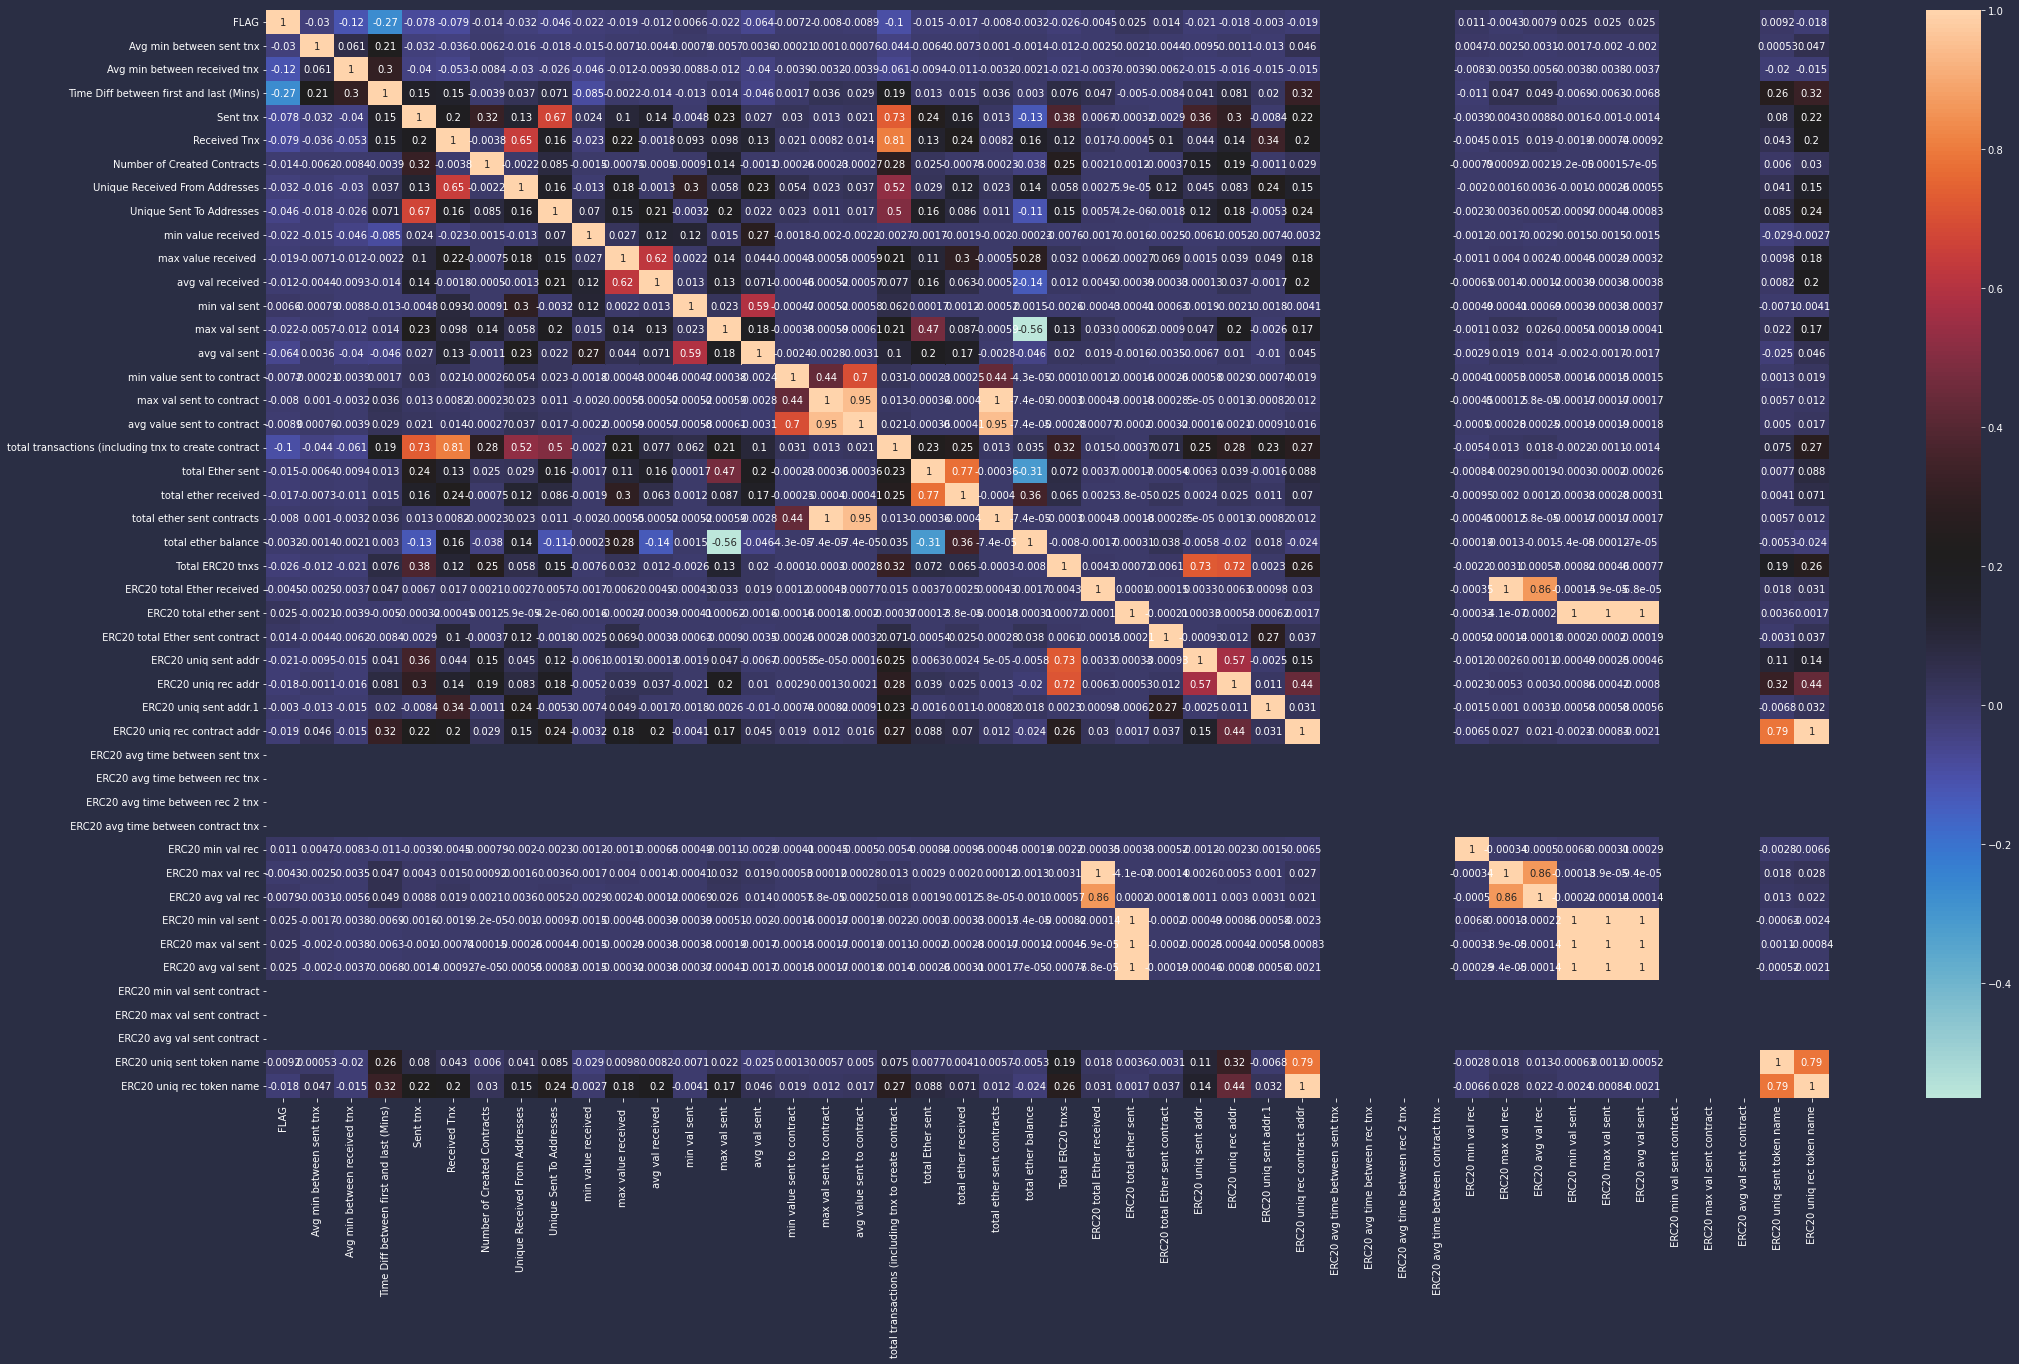

In [ ]:
corr = df.corr()

plt.figure(figsize=(35,20))

sns.heatmap(corr,
            annot=True,
            cmap='icefire')

We mainly want to focus on the column named "FLAG" which we'll be predicting later on.

Since no correlation can be observed in regards to this column, we won't be including the heatmap in the discussion

In [ ]:
fraud = df['FLAG'] == 1
non_fraud = df['FLAG'] == 0

In [ ]:
df['FLAG'].value_counts()

0    7661
1    2179
Name: FLAG, dtype: int64

## Data Visualization

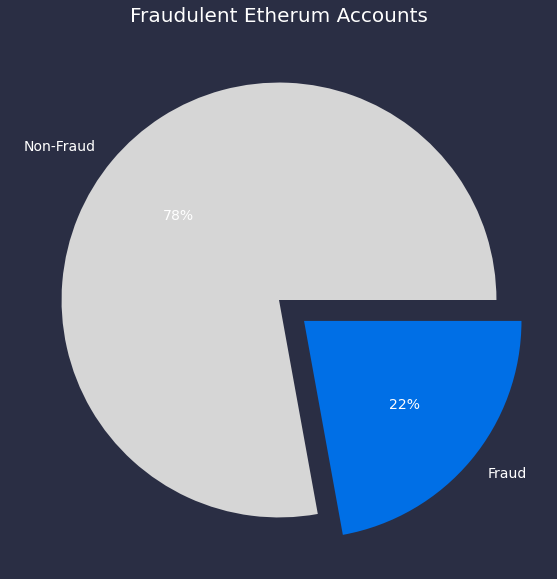

In [ ]:
pie = df['FLAG'].value_counts()
plt.figure(figsize=(15,10))

plt.title('Fraudulent Etherum Accounts',
          fontsize=20)
plt.pie(pie,
        labels=['Non-Fraud','Fraud'],
        autopct='%.0f%%',
        explode=[0, 0.15],
        textprops={'fontsize': 14},
        colors=palette);

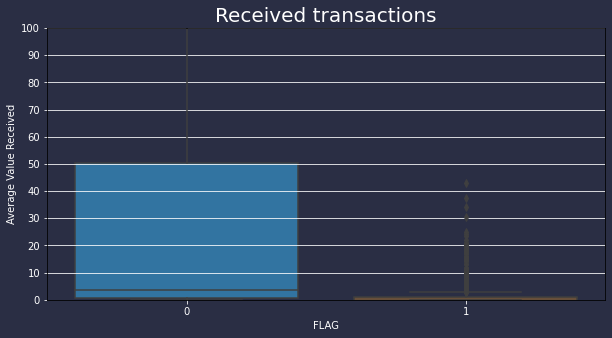

In [ ]:

plt.figure(figsize=(10,5))

plt.title('Received transactions',
          fontsize=20)
plt.ylim(0,100)

sns.boxplot(x=df['FLAG'],
            y=df['avg val received']).set_yticks(range(0,110,10))
plt.ylabel('Average Value Received');

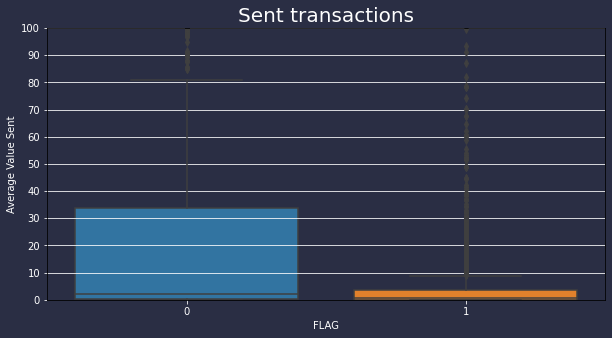

In [ ]:

plt.figure(figsize=(10,5))
plt.title('Sent transactions',
          fontsize=20)
plt.ylim(0,100)
sns.boxplot(x=df['FLAG'],
            y=df['avg val sent']).set_yticks(range(0,110,10))
plt.ylabel('Average Value Sent');

In [ ]:
df['total_eth_transacted'] = df['total Ether sent'] + df['total ether received']
df['total_avg_transacted'] = df['avg val received'] + df['avg val sent']
df['total_eth_in_usd'] = df['total_eth_transacted'] * 1271

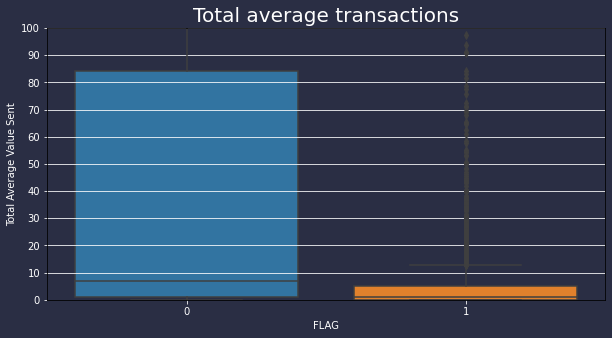

In [ ]:
plt.figure(figsize=(10,5))
plt.title('Total average transactions',
          fontsize=20)
plt.ylim(0,100)
sns.boxplot(x=df['FLAG'],
            y=df['total_avg_transacted']).set_yticks(range(0,110,10))
plt.ylabel('Total Average Value Sent');

''

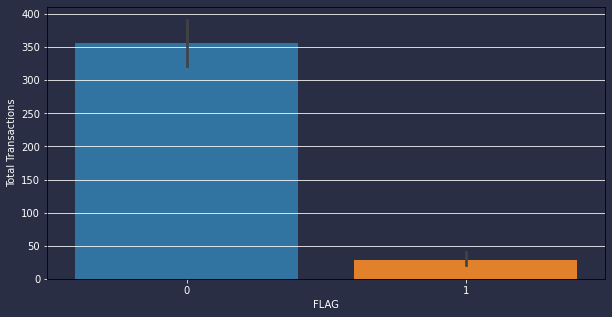

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x=df['FLAG'],
            y=df['total transactions (including tnx to create contract'])
plt.ylabel('Total Transactions');

# Part 2: Data preparation

In [ ]:
scaler = StandardScaler()
impute = SimpleImputer(strategy='mean')

In [ ]:
X = df.drop(columns=['FLAG','total_eth_transacted','total_avg_transacted','total_eth_in_usd'])
y = df['FLAG']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,test_size=0.2,shuffle=True)

In [ ]:

num = make_column_selector(dtype_include='number')
num_pipe = make_pipeline(impute,scaler)
num_tuple = (num_pipe,num)

processor = make_column_transformer(num_tuple,remainder='passthrough')

This is the part where we have imputed the null rows with the mean value of each column. 

We would also want to scale our data so that we can do a dimension reduction and help our algorithm help run and learn faster

In [ ]:
X_train = processor.fit_transform(X_train)
X_test = processor.transform(X_test)

In [ ]:
pca = PCA()

pca_X_train = pca.fit_transform(X_train)
pca_X_test = pca.transform(X_test)

In [ ]:
n_cols = X_train.shape[1]
n_cols

45

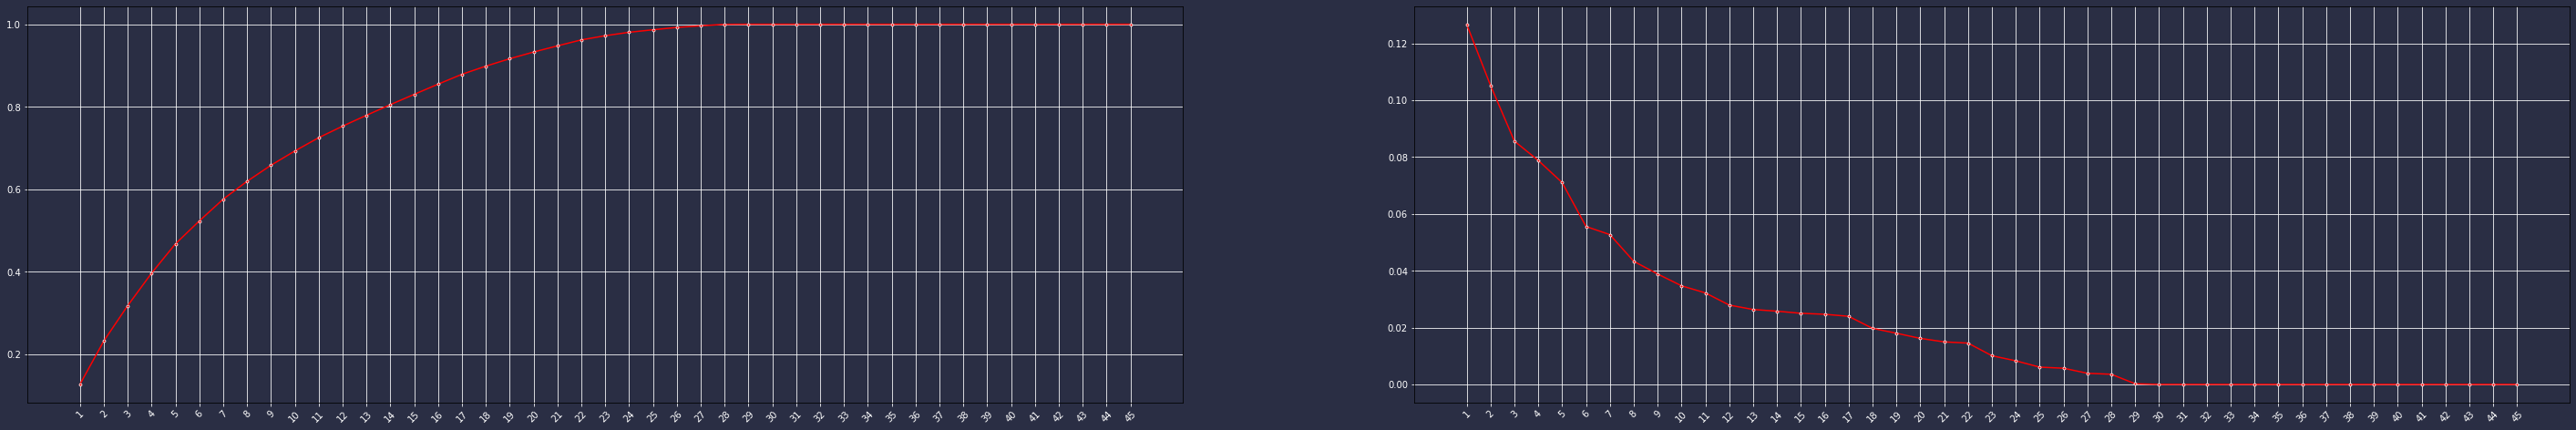

In [ ]:
plt.figure(figsize=(50,8))

plt.tight_layout()

plt.subplot(1,2,1)
sns.lineplot(y=pca.explained_variance_ratio_.cumsum(),x=range(1,46), marker= '.',color='r')
plt.xticks(ticks=range(1,46), fontsize=10,rotation=45)

plt.subplot(1,2,2)
sns.lineplot(y=pca.explained_variance_ratio_, marker = '.',x=range(1,46),color='r')
plt.xticks(ticks=range(1,46), fontsize=10,rotation=45);

Plot shows that the best number of features would be at 22, with this number of features, we still have over 90% of explainable variable.

In [ ]:
pca22 = PCA(n_components=22)

pc22_train = pca22.fit_transform(X_train)
pc22_test = pca22.transform(X_test)

In [ ]:
n_cols = pc22_train.shape[1]
n_cols

22

In [ ]:
class_model = Sequential()
class_model.add(Dense(30, activation = 'relu', input_dim = n_cols))
class_model.add(Dense(15, activation = 'relu'))
class_model.add(Dense(5, activation = 'relu'))
class_model.add(Dense(1, activation = 'sigmoid'))
class_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 30)                690       
                                                                 
 dense_21 (Dense)            (None, 15)                465       
                                                                 
 dense_22 (Dense)            (None, 5)                 80        
                                                                 
 dense_23 (Dense)            (None, 1)                 6         
                                                                 
Total params: 1,241
Trainable params: 1,241
Non-trainable params: 0
_________________________________________________________________


In [ ]:
class_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

model_1st = class_model.fit(pc22_train,y_train,
                            validation_data=(pc22_test, y_test),
                            epochs=200,
                            callbacks=[EarlyStopping(patience=10)])

Epoch 1/200
246/246 [==============================] - 1s 3ms/step - loss: 0.4675 - accuracy: 0.7998 - val_loss: 0.3683 - val_accuracy: 0.8516
Epoch 2/200
246/246 [==============================] - 1s 3ms/step - loss: 0.3433 - accuracy: 0.8453 - val_loss: 0.2995 - val_accuracy: 0.8577
Epoch 3/200
246/246 [==============================] - 1s 3ms/step - loss: 0.2960 - accuracy: 0.8556 - val_loss: 0.2900 - val_accuracy: 0.8720
Epoch 4/200
246/246 [==============================] - 1s 3ms/step - loss: 0.2722 - accuracy: 0.8661 - val_loss: 0.2775 - val_accuracy: 0.8740
Epoch 5/200
246/246 [==============================] - 1s 3ms/step - loss: 0.2537 - accuracy: 0.8901 - val_loss: 0.2663 - val_accuracy: 0.9329
Epoch 6/200
246/246 [==============================] - 1s 2ms/step - loss: 0.2389 - accuracy: 0.9143 - val_loss: 0.2535 - val_accuracy: 0.9263
Epoch 7/200
246/246 [==============================] - 1s 2ms/step - loss: 0.2234 - accuracy: 0.9305 - val_loss: 0.2549 - val_accuracy: 0.9395

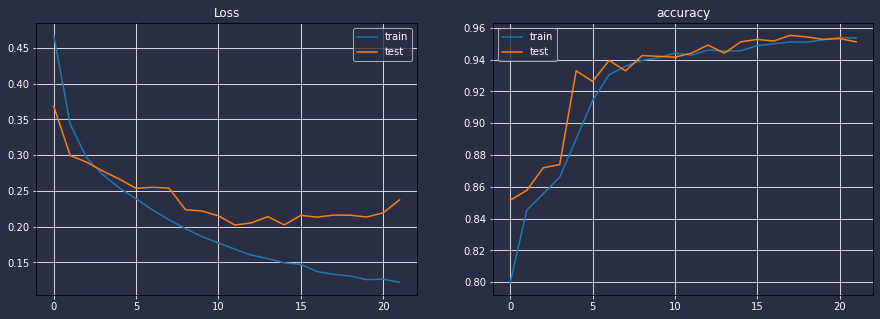

In [ ]:
plot_history(model_1st,'accuracy')

Despite the model showing a good performance, we can still observe loss on the testing scores

Training Scores
246/246 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      6106
           1       0.92      0.86      0.89      1766

    accuracy                           0.95      7872
   macro avg       0.94      0.92      0.93      7872
weighted avg       0.95      0.95      0.95      7872



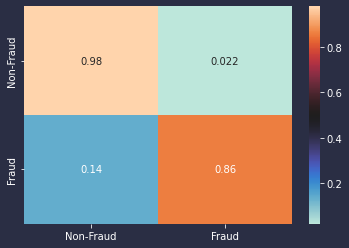



Testing Scores
62/62 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1555
           1       0.91      0.85      0.88       413

    accuracy                           0.95      1968
   macro avg       0.94      0.91      0.92      1968
weighted avg       0.95      0.95      0.95      1968



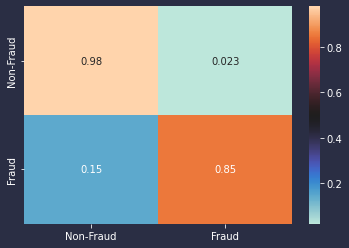

In [ ]:
# Make predicitons and evaluate your model
print('Training Scores')

# Define labels for the confusion matrix
labels = ['Non-Fraud', 'Fraud']

# Get training predictions and round them to integers instead of floats
train_preds = np.rint(class_model.predict(pc22_train))

# Classification Report
print(classification_report(y_train, train_preds))

# Confusion Matrix
conf_mat = confusion_matrix(y_train, train_preds, normalize='true')
sns.heatmap(conf_mat, xticklabels=labels, yticklabels=labels, annot=True,cmap='icefire')
plt.show()
print('\n')
print('Testing Scores')

# Get testing predictions and round them to integers
test_preds = np.rint(class_model.predict(pc22_test))

# Classification report
print(classification_report(y_test, test_preds))

# Confusion Matrix
conf_mat = confusion_matrix(y_test, test_preds, normalize='true')
sns.heatmap(conf_mat, xticklabels=labels, yticklabels=labels, annot=True,cmap='icefire')
plt.show()

The default model performed well having 95% accuracy for testing scores and 91%  for macro average of recall.

Since we want to minimize the number of false negatives, we will be decreasing the threshold and try to increase the TPR of the model.

In [ ]:
class_model2 = Sequential()
class_model2.add(Dense(30, activation = 'relu', input_dim = n_cols))
class_model2.add(Dropout(.2))
class_model2.add(Dense(15, activation = 'relu'))
class_model2.add(Dropout(.1))
class_model2.add(Dense(5, activation = 'relu'))
class_model2.add(Dense(1, activation = 'sigmoid'))
class_model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 30)                690       
                                                                 
 dropout_6 (Dropout)         (None, 30)                0         
                                                                 
 dense_17 (Dense)            (None, 15)                465       
                                                                 
 dropout_7 (Dropout)         (None, 15)                0         
                                                                 
 dense_18 (Dense)            (None, 5)                 80        
                                                                 
 dense_19 (Dense)            (None, 1)                 6         
                                                                 
Total params: 1,241
Trainable params: 1,241
Non-traina

In [ ]:
class_model2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = [BinaryAccuracy(name='accuracy',threshold=0.2)])

model_2nd = class_model2.fit(pc22_train,y_train,
                            validation_data=(pc22_test, y_test),
                            epochs=200,
                            callbacks=[EarlyStopping(patience=10)])

Epoch 1/200
246/246 [==============================] - 1s 4ms/step - loss: 0.4605 - accuracy: 0.5608 - val_loss: 0.3666 - val_accuracy: 0.7886
Epoch 2/200
246/246 [==============================] - 1s 3ms/step - loss: 0.3735 - accuracy: 0.7591 - val_loss: 0.3191 - val_accuracy: 0.8206
Epoch 3/200
246/246 [==============================] - 1s 3ms/step - loss: 0.3455 - accuracy: 0.7847 - val_loss: 0.2868 - val_accuracy: 0.8196
Epoch 4/200
246/246 [==============================] - 1s 2ms/step - loss: 0.3286 - accuracy: 0.8037 - val_loss: 0.2739 - val_accuracy: 0.7988
Epoch 5/200
246/246 [==============================] - 1s 3ms/step - loss: 0.3018 - accuracy: 0.8196 - val_loss: 0.2525 - val_accuracy: 0.8125
Epoch 6/200
246/246 [==============================] - 1s 3ms/step - loss: 0.2866 - accuracy: 0.8356 - val_loss: 0.2360 - val_accuracy: 0.8166
Epoch 7/200
246/246 [==============================] - 1s 3ms/step - loss: 0.2649 - accuracy: 0.8408 - val_loss: 0.2197 - val_accuracy: 0.8328

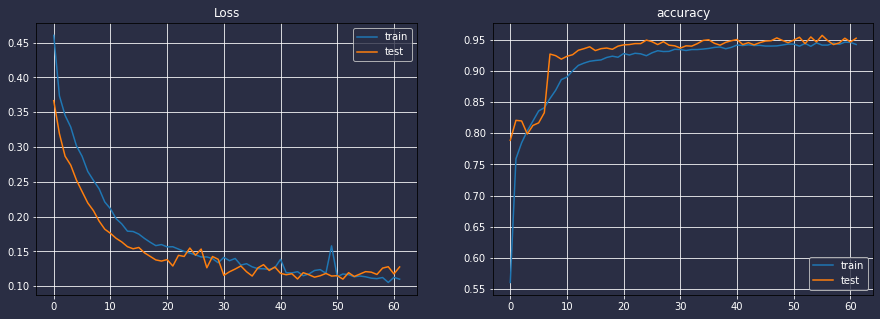

In [ ]:
plot_history(model_2nd,'accuracy')

Training Scores
246/246 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      6106
           1       0.94      0.89      0.92      1766

    accuracy                           0.96      7872
   macro avg       0.96      0.94      0.95      7872
weighted avg       0.96      0.96      0.96      7872



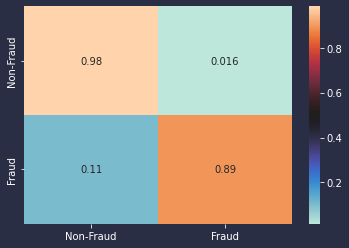



Testing Scores
62/62 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1555
           1       0.95      0.88      0.92       413

    accuracy                           0.97      1968
   macro avg       0.96      0.94      0.95      1968
weighted avg       0.97      0.97      0.97      1968



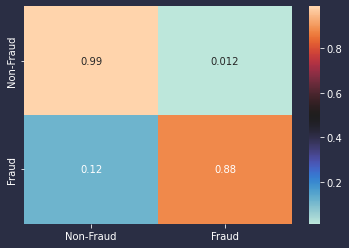

In [ ]:
# Make predicitons and evaluate your model
print('Training Scores')

# Define labels for the confusion matrix
labels = ['Non-Fraud', 'Fraud']

# Get training predictions and round them to integers instead of floats
train_preds = np.rint(class_model2.predict(pc22_train))

# Classification Report
print(classification_report(y_train, train_preds))

# Confusion Matrix
conf_mat = confusion_matrix(y_train, train_preds, normalize='true')
sns.heatmap(conf_mat, xticklabels=labels, yticklabels=labels, annot=True,cmap='icefire')
plt.show()
print('\n')
print('Testing Scores')

# Get testing predictions and round them to integers
test_preds = np.rint(class_model2.predict(pc22_test))

# Classification report
print(classification_report(y_test, test_preds))

# Confusion Matrix
conf_mat = confusion_matrix(y_test, test_preds, normalize='true')
sns.heatmap(conf_mat, xticklabels=labels, yticklabels=labels, annot=True,cmap='icefire')
plt.show()